In [1]:
import requests
import pandas as pd
import numpy as np
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
ss = StandardScaler()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#web app api base url
baseurl = 'https://ats-ana-prt-funapp-db-api.azurewebsites.net/api/sync/'

#web app token, please keep it confidential
token = '5d577dfc-dc58-447a-9842-15b49a642218'

In [ ]:
#send http request to api endpoint
def get(path):
    return requests.get(baseurl+path, 
            headers={ "Content-Type": "application/json", "authorization": "Bearer " + token }).json()

### Crude Oil Production Data

In [ ]:
#get production
def get_production(split='country',category='',start='',end='',country='',grade=''):
    '''
    split: how to split result, country or grade. default country
    category: Crude Oil or Condensate. default both included
    start: Starting month, format YYYY-MM-01. default 8 month before
    end: Ending month, format YYYY-MM-01. default 3 month after
    country: Which country's production. default all countries. Multiple countries split with comma: Saudi Arabia,Qatar
    grade: Which grade is included. default all grades. Multiple grades split with comma: Urals,Arab Light
    
    '''
    res = get('production?split=' + split + '&category=' + category + '&start=' + start\
                  + '&end=' + end + '&country=' + country + '&grade=' + grade)
    return res

In [ ]:
res = get_production(start='2010-01-01',end='2022-09-01')
#res

In [ ]:
print(res)

[{'name': 'Russia', 'data': [{'date': '2010-01-01T00:00:00.000Z', 'country': 'Russia', 'y': 10042}, {'date': '2010-02-01T00:00:00.000Z', 'country': 'Russia', 'y': 10079}, {'date': '2010-03-01T00:00:00.000Z', 'country': 'Russia', 'y': 10130}, {'date': '2010-04-01T00:00:00.000Z', 'country': 'Russia', 'y': 10077}, {'date': '2010-05-01T00:00:00.000Z', 'country': 'Russia', 'y': 10132}, {'date': '2010-06-01T00:00:00.000Z', 'country': 'Russia', 'y': 10152}, {'date': '2010-07-01T00:00:00.000Z', 'country': 'Russia', 'y': 10137}, {'date': '2010-08-01T00:00:00.000Z', 'country': 'Russia', 'y': 10064}, {'date': '2010-09-01T00:00:00.000Z', 'country': 'Russia', 'y': 10185}, {'date': '2010-10-01T00:00:00.000Z', 'country': 'Russia', 'y': 10270}, {'date': '2010-11-01T00:00:00.000Z', 'country': 'Russia', 'y': 10243}, {'date': '2010-12-01T00:00:00.000Z', 'country': 'Russia', 'y': 10164}, {'date': '2011-01-01T00:00:00.000Z', 'country': 'Russia', 'y': 10215}, {'date': '2011-02-01T00:00:00.000Z', 'country': 

In [ ]:
dfProd = pd.DataFrame(columns = ['date', 'country', 'y'])
for x in range(0,len(res)):
    #print(pd.DataFrame(res[x]['data']))
    dfProd = dfProd.append(pd.DataFrame(res[x]['data']), ignore_index=True)
dfProd.head()

,date,country,y
0,2010-01-01T00:00:00.000Z,Russia,10042
1,2010-02-01T00:00:00.000Z,Russia,10079
2,2010-03-01T00:00:00.000Z,Russia,10130
3,2010-04-01T00:00:00.000Z,Russia,10077
4,2010-05-01T00:00:00.000Z,Russia,10132


In [ ]:
#from dateutil.parser import parse
dfProd['date'] =  pd.to_datetime(dfProd['date']).dt.date
dfProd.head()

,date,country,y
0,2010-01-01,Russia,10042
1,2010-02-01,Russia,10079
2,2010-03-01,Russia,10130
3,2010-04-01,Russia,10077
4,2010-05-01,Russia,10132


In [ ]:
dfProdPivot = dfProd.pivot_table(index = 'date', columns = ['country'], values = 'y')
#dfProdPivot.index = pd.to_datetime(dfProdPivot.index)
dfProdPivot.head()

country,Algeria,Angola,Argentina,Australia,Azerbaijan,Brazil,Canada,Chad,China,Colombia,...,Russia,Saudi Arabia,South Sudan,Thailand,Turkmenistan,UAE,United Kingdom,United States,Venezuela,Vietnam
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,1488.0,1884.0,623.0,402.0,1017.0,2014.0,2445.0,120.0,3968.0,741.0,...,10042.0,8242.0,387.0,228.0,184.0,2645.0,1352.0,5364.0,2706.0,263.0
2010-02-01,1472.0,1925.0,622.0,387.0,991.0,2033.0,2664.0,124.0,3939.0,758.0,...,10079.0,8266.0,364.0,230.0,175.0,2643.0,1327.0,5497.0,3234.0,271.0
2010-03-01,1439.0,1901.0,624.0,508.0,1050.0,2056.0,2689.0,124.0,3984.0,765.0,...,10130.0,8267.0,356.0,244.0,171.0,2650.0,1417.0,5466.0,2917.0,264.0
2010-04-01,1446.0,1879.0,623.0,553.0,1083.0,2098.0,2662.0,124.0,3959.0,777.0,...,10077.0,8304.0,352.0,231.0,169.0,2665.0,1396.0,5320.0,2775.0,258.0
2010-05-01,1435.0,1844.0,621.0,502.0,1078.0,2095.0,2721.0,124.0,4040.0,776.0,...,10132.0,8332.0,352.0,240.0,174.0,2690.0,1231.0,5307.0,3132.0,281.0


In [ ]:
#Use this if saving for the first time
#dfProdPivot.to_excel('/content/drive/MyDrive/Berkeley/CrudeProductionData.xlsx')

In [ ]:
#Read Prod data from file, already converted to timeseries format
dfProdPivot = pd.read_excel('/content/drive/MyDrive/Berkeley/CrudeProductionData.xlsx', index_col = 'date')

dfProdPivot.head()

,Algeria,Angola,Argentina,Australia,Azerbaijan,Brazil,Canada,Chad,China,Colombia,...,Russia,Saudi Arabia,South Sudan,Thailand,Turkmenistan,UAE,United Kingdom,United States,Venezuela,Vietnam
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1282,1647,500,275,796,2709,4111,114,3895,860,...,11110,10340,149,248,231,3360,968,8873,2221,292
2017-02-01,1301,1629,489,271,778,2698,4147,111,3895,864,...,11106,10485,150,244,237,3287,969,9107,2222,289
2017-03-01,1291,1590,488,289,734,2573,3933,125,3907,804,...,11049,10434,150,239,236,3266,949,9155,2201,287
2017-04-01,1297,1656,457,274,783,2562,3581,122,3895,858,...,10994,10462,149,231,237,3285,932,9103,2190,288
2017-05-01,1304,1592,472,292,787,2675,3707,112,3834,852,...,10950,10423,149,240,238,3275,958,9173,2179,287


In [ ]:
fig = px.line(dfProdPivot)
fig.update_layout(yaxis_title = 'Production in Thousands bbls per day', title = 'Crude and Condensate Production', 
                  font_size = 15)
fig.show()

### Refinery Turnaround Data

The below is a snapshot of top refining countries in the world

https://www.iea.org/reports/key-world-energy-statistics-2020/transformation

In [ ]:
def get_refinery(type,unit='',start='',end='',region='',sub_region='',country=''):
    # type: turnarounds, capacity or expansion
    # unit: refinery unit
    # CDU: Atmospheric Distillation
    # DS RES: Residual Hydrotreater
    # DS VGO: FCCU Feed Hydrotreater
    # HOU COKER: Delayed Coker
    # HOU THERM: Thermal Cracker
    # HOU VIS: Visbreaker
    # MOG ALKY: Hydrofluoric Alkylation
    # MOG ISOM: Isomerization
    # MOG MTBE: MOG MTBE
    # OTH: Lube Oil Hydrotreater
    # SPL CDY: Condensate Splitter
    # VDU: Vacuum Distillation
    # CRKG FCC: FCCU (Fluid Catalytic Cracker)
    # DS MOG: FCCU Gasoline Hydrotreater
    # CRU: CCR(Continuous Catalytic Reformer)
    # CHEM ETHYLENE: CHEM ETHYLENE
    # DS NAP: Reformer Feed Hydrotreater
    # CRKG RHCU: Residual Hydrocracker
    # DS DIST: Distillate Hydrotreater
    # CHEM PDH: CHEM PDH
    # CRKG HCU: Distillate Hydrocracker
    #region: South America, Asia, North America, Europe, Africa, Oceania, Middle America
    #sub_region: Western Europe, Southern Europe, Western Asia, Russia, Eastern Europe, Caribbean, Central Asia, Southeast Asia, South Asia, 
    #East Asia, Northern Europe, South America, Oceania, Africa, Mexico, Central America, United States, Canada
    #country: Country name
    #region, sub_region and country can be single value or multiple split by comma. e.g. region='Asia,Europe'
    res = get(type + '?unit=' + unit + '&start=' + start + '&end=' + end + '&region=' + region + '&sub_region=' + sub_region + '&country=' + country)
    return res

In [ ]:
major_refiners = ['United States', 'China', 'Russia', 'India', 'South Korea','Japan', 'Saudi Arabia', 'Germany', 
                  'Brazil', 'Canada', 'Iran', 'ROW']
res = get_refinery(type='turnarounds', unit = 'CDU', start='2010-01-01', end = '2022-08-01', 
                   country = 'United States,China,Russia,India,South Korea,Japan,Saudi Arabia,Germany,Brazil,Canada,Iran')
#res

In [ ]:
df = pd.DataFrame(res['data'])
df.head()

,name,date,CDU
0,Brazil,2012-01-01,0
1,Canada,2012-01-01,0
2,China,2012-01-01,0
3,Germany,2012-01-01,0
4,India,2012-01-01,0


In [ ]:
df = df[~(df['name'] == 'Total')]
df.head()

,name,date,CDU
0,Brazil,2012-01-01,0
1,Canada,2012-01-01,0
2,China,2012-01-01,0
3,Germany,2012-01-01,0
4,India,2012-01-01,0


In [ ]:
print(df['name'].value_counts())
df.shape

Brazil           128
Canada           128
China            128
Germany          128
India            128
Iran             128
Japan            128
Russia           128
Saudi Arabia     128
South Korea      128
United States    128
Name: name, dtype: int64


(1408, 3)

In [ ]:
dfRef = df.pivot_table(index = 'date', columns = 'name', values = 'CDU')
dfRef.index = pd.to_datetime(dfRef.index)
dfRef.head()

name,Brazil,Canada,China,Germany,India,Iran,Japan,Russia,Saudi Arabia,South Korea,United States
date,,,,,,,,,,,
2012-01-01,0,0,0,0,0,0,0,0,0,0,0
2012-02-01,0,0,0,0,0,0,0,0,0,0,0
2012-03-01,0,0,0,0,0,0,0,0,0,0,0
2012-04-01,0,0,0,0,0,0,0,0,0,0,0
2012-05-01,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dfRef.columns = [x.replace(' ', '_') + '_CDU_TAR' for x in dfRef.columns]

In [ ]:
#dfMelt = df.melt(id_vars = ['name', 'date'], var_name = 'TAR_Type', value_name = 'Vol(kbd)')
#.sort_values(by = ['name', 'TAR_Type', 'date'])
#dfMelt.head()
#dfRef.head()

In [ ]:
#Use this when saving for first time
#dfRef.to_excel('/content/drive/MyDrive/Berkeley/Refinery_TARs.xlsx')

In [ ]:
dfRef = pd.read_excel('/content/drive/MyDrive/Berkeley/Refinery_TARs.xlsx', index_col = 'date')
dfRef.head()

,Brazil_CDU_TAR,Canada_CDU_TAR,China_CDU_TAR,Germany_CDU_TAR,India_CDU_TAR,Iran_CDU_TAR,Japan_CDU_TAR,Russia_CDU_TAR,Saudi_Arabia_CDU_TAR,South_Korea_CDU_TAR,United_States_CDU_TAR
date,,,,,,,,,,,
2012-01-01,0,0,0,0,0,0,0,0,0,0,0
2012-02-01,0,0,0,0,0,0,0,0,0,0,0
2012-03-01,0,0,0,0,0,0,0,0,0,0,0
2012-04-01,0,0,0,0,0,0,0,0,0,0,0
2012-05-01,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#dfRef = pd.read_excel('data/Refinery_TARs.xlsx')
fig = px.line(dfRef)
fig.update_layout(yaxis_title = 'CDU TAR (kbd)', title = 'Refinery CDU Turnarounds', 
                  font_size = 15)
fig.show()

### Oil Flow Data

In [ ]:
def get_flows(originLevel,destinationLevel,originValue,destinationValue,split='destination',year=2022,family_id=16,flow='import',useKT= '',grade=''):
    res = get('flows?originLevel=' + originLevel + '&destinationLevel=' + destinationLevel + '&originValue=' + originValue\
              + '&destinationValue=' + destinationValue + '&split' + split + '&year=' + str(year)\
              + '&family_id=' + str(family_id) + '&flow=' + flow + '&useKT=' + useKT + '&grade=' + grade)
    
    return res

In [ ]:
#split: how to split result, origin, destination or grade. default grade

#year: which year's data

#family_id: product family:
    # 14    Asphalt/Bitumen
    # 13    Biodiesel
    # 15    Condensates
    # 16    Crude
    # 19    Diesel/Gasoil
    # 18    Fuel Oil
    # 20    Gasoline/Blending Components
    # 21    Jet/Kero
    # 22    LPG+
    # 23    Naphtha
    # 24    Other Clean Products
    # 17    Refinery Feedstock / Intermediates
    # 1     LNG

#flow: import or export, import use arrival month, export use loading month
#useKT: UOM. if empty, flow data's unit will be KBD, if useKT=1, flow data unit will be KT
#grade: grade filter. if empty, includes all grades. if e.g. grade=Light-Sour,Light-Sweet, will only include the specific grades
#originLevel: origin geography level. region, sub_region or country
#destinationLevel: destination geography level. region, sub_region or country
#originValue: origin geography values
#destinationValue: destination geography values

In [ ]:
top_crude_exporters = ['Saudi Arabia', 'Russia', 'Canada', 'Iraq', 'UAE', 'Nigeria', 
                       'Kuwait', 'Norway', 'Iran']

In [ ]:
dfAllFlows = pd.DataFrame(columns = ['Name', 'date', 'Vol(kbd)'])

In [ ]:
res=get_flows(family_id=16, year=2022, flow='export', originLevel='country',originValue='Saudi Arabia',
                destinationLevel='country', destinationValue='China,Inda,South Korea,Japan,Germany,Spain',split='destination')
print(res)

{'data': [{'name': 'China', 'data': [1441, 1670, 1752, 1947, 1251, 1550, 1648, 1664, 1009, 1054, 546, 0]}, {'name': 'Japan', 'data': [1135, 1260, 1189, 931, 825, 1105, 1069, 1119, 554, 333, 139, 0]}, {'name': 'South Korea', 'data': [1044, 988, 734, 965, 949, 905, 1094, 975, 516, 459, 195, 0]}, {'name': 'Inda', 'data': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'name': 'Germany', 'data': [0, 0, 0, 0, 0, 92, 0, 32, 0, 0, 0, 0]}, {'name': 'Spain', 'data': [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}], 'all': [{'Name': 'China', '2022-01-01': 1441, '2022-02-01': 1670, '2022-03-01': 1752, '2022-04-01': 1947, '2022-05-01': 1251, '2022-06-01': 1550, '2022-07-01': 1648, '2022-08-01': 1664, '2022-09-01': 1009, '2022-10-01': 1054, '2022-11-01': 546, '2022-12-01': 0}, {'Name': 'Japan', '2022-01-01': 1135, '2022-02-01': 1260, '2022-03-01': 1189, '2022-04-01': 931, '2022-05-01': 825, '2022-06-01': 1105, '2022-07-01': 1069, '2022-08-01': 1119, '2022-09-01': 554, '2022-10-01': 333, '2022-11-01': 139, '2022-12-0

In [ ]:
pd.DataFrame(res['all'])

,Name,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
0,China,1441,1670,1752,1947,1251,1550,1648,1664,1009,1054,546,0
1,Japan,1135,1260,1189,931,825,1105,1069,1119,554,333,139,0
2,South Korea,1044,988,734,965,949,905,1094,975,516,459,195,0
3,Spain,0,5,0,0,0,0,0,0,0,0,0,0
4,Germany,0,0,0,0,0,92,0,32,0,0,0,0


In [ ]:
Destinations = 'China,India,United States,South Korea,Japan,Germany,Spain,Italy,Netherlands,Thailand,Taiwan,France'
DestinationsExclUS = 'China,India,South Korea,Japan,Germany,Spain,Italy,Netherlands,Thailand,Taiwan,France'

Years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
dfAllFlows = pd.DataFrame(columns = ['Name', 'date', 'Vol(kbd)'])
for exporter in top_crude_exporters:
    for yr in Years:
        #print(f'fetching data for {exporter} for year {yr}')
        res=get_flows(family_id=16, year=yr, flow='export', originLevel='country',originValue=exporter,
                destinationLevel='country', destinationValue=Destinations,split='destination')
        if len(pd.DataFrame(res['all']))>0:
          dfFlow = pd.DataFrame(res['all']).melt(id_vars=['Name'], var_name = 'date' , value_name = 'Vol(kbd)')
          dfFlow['name'] = exporter + '_to_' + dfFlow['Name']
          dfAllFlows = pd.concat([dfAllFlows, dfFlow], ignore_index=True)

In [ ]:
dfAllFlows.shape

(7464, 4)

#### Getting data for United States separately as its both a producer and an importer

In [ ]:
top_crude_exporters = ['Saudi Arabia', 'Russia', 'Canada', 'Iraq', 'UAE', 'Nigeria', 
                       'Kuwait', 'Kazakhstan', 'Norway', 'Iran']
Destinations = 'China,India,United States,South Korea,Japan,Germany,Spain,Italy,Netherlands,Thailand,Taiwan,France'
DestinationsExclUS = 'China,India,South Korea,Japan,Germany,Spain,Italy,Netherlands,Thailand,Taiwan,France'
Years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

exporter = 'United States'

for yr in Years:
    res=get_flows(family_id=16, year=yr, flow='export', originLevel='country',originValue=exporter,
                    destinationLevel='country', destinationValue=DestinationsExclUS,split='destination')
    if len(pd.DataFrame(res['all']))>0:
      dfFlow = pd.DataFrame(res['all']).melt(id_vars=['Name'], var_name = 'date' , value_name = 'Vol(kbd)')
      dfFlow['Name'] = exporter + '_to_' + dfFlow['Name']
      dfAllFlows = pd.concat([dfAllFlows, dfFlow], ignore_index=True)

In [ ]:
dfAllFlows.shape

(8412, 4)

In [ ]:
dfAllFlows.head()

,Name,date,Vol(kbd),name
0,China,2015-01-01,0,Saudi Arabia_to_China
1,India,2015-01-01,0,Saudi Arabia_to_India
2,United States,2015-01-01,0,Saudi Arabia_to_United States
3,South Korea,2015-01-01,0,Saudi Arabia_to_South Korea
4,France,2015-01-01,0,Saudi Arabia_to_France


In [ ]:
#dfAllFLowsSoFar = dfAllFlows.copy()

In [ ]:
dfAllFlowsPivot = dfAllFlows.pivot_table(index='date', columns = 'Name', values = 'Vol(kbd)')
dfAllFlowsPivot.index = pd.to_datetime(dfAllFlowsPivot.index)
dfAllFlowsPivot.head()

Name,China,France,Germany,India,Italy,Japan,Netherlands,South Korea,Spain,Taiwan,...,United States_to_France,United States_to_Germany,United States_to_India,United States_to_Italy,United States_to_Japan,United States_to_Netherlands,United States_to_South Korea,United States_to_Spain,United States_to_Taiwan,United States_to_Thailand
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2015-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2015-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2015-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2015-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN


In [ ]:
dfAllFlowsPivot = dfAllFlowsPivot.fillna(0)

In [ ]:
#Use this to export data first time
#dfAllFlowsPivot.to_excel('/content/drive/MyDrive/Berkeley/Crude_Flows.xlsx')

In [ ]:
#import existing data
dfAllFlowsPivot = pd.read_excel('/content/drive/MyDrive/Berkeley/Crude_Flows.xlsx', index_col='date')
dfAllFlowsPivot.head()

,China,France,Germany,India,Italy,Japan,Netherlands,South Korea,Spain,Taiwan,...,United States_to_France,United States_to_Germany,United States_to_India,United States_to_Italy,United States_to_Japan,United States_to_Netherlands,United States_to_South Korea,United States_to_Spain,United States_to_Taiwan,United States_to_Thailand
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fig = px.line(dfAllFlowsPivot)
fig.update_layout(yaxis_title = 'Crude Flows(kbd)', title = 'Crude Flows by Source and Destination', 
                  font_size = 15)
fig.show()

## Getting the Runs for the major refiners in the world

In [ ]:
top_crude_exporters = 'Saudi Arabia,Russia,Canada,Iraq,UAE,Nigeria,Kuwait,Norway,Iran'
top_crude_importers = 'China,India,United States,South Korea,Japan,Germany,Spain,Italy,Netherlands,Thailand,Taiwan,France'
top_refiners = 'United States,China,Russia,India,South Korea,Japan,Saudi Arabia,Germany,Brazil,Canada,Iran'

In [ ]:
#get refinery rauns
def get_runs(start='',end='',region='',sub_region='',country=''):

    res = get('refinery-runs?start=' + start + '&end=' + end + '&region=' + region + '&sub_region=' + sub_region + '&country=' + country)

    return res

#region,subregion,country,start,end is similar with get_refinery, no unit

In [ ]:
res1 = get_runs(start = '2010-01-10', end = '2022-09-01', country=top_refiners)
print(res1)

{'label': 'Runs', 'start': '2010-01-10', 'end': '2022-09-01', 'countries': ['United States', 'China', 'Russia', 'India', 'South Korea', 'Japan', 'Saudi Arabia', 'Germany', 'Brazil', 'Canada', 'Iran'], 'data': [{'name': 'Brazil', 'date': '2016-01-01', 'runs': 1939}, {'name': 'Canada', 'date': '2016-01-01', 'runs': 1676}, {'name': 'China', 'date': '2016-01-01', 'runs': 10420}, {'name': 'Germany', 'date': '2016-01-01', 'runs': 1918}, {'name': 'India', 'date': '2016-01-01', 'runs': 5064}, {'name': 'Iran', 'date': '2016-01-01', 'runs': 1790}, {'name': 'Japan', 'date': '2016-01-01', 'runs': 3482}, {'name': 'Russia', 'date': '2016-01-01', 'runs': 5539}, {'name': 'Saudi Arabia', 'date': '2016-01-01', 'runs': 2468}, {'name': 'South Korea', 'date': '2016-01-01', 'runs': 2952}, {'name': 'United States', 'date': '2016-01-01', 'runs': 15952}, {'name': 'Total', 'date': '2016-01-01', 'runs': 15952}, {'name': 'Brazil', 'date': '2016-02-01', 'runs': 1890}, {'name': 'Canada', 'date': '2016-02-01', 'runs

In [ ]:
dfRuns = pd.DataFrame(res1['data'])
dfRuns.head()

,name,date,runs
0,Brazil,2016-01-01,1939
1,Canada,2016-01-01,1676
2,China,2016-01-01,10420
3,Germany,2016-01-01,1918
4,India,2016-01-01,5064


In [ ]:
dfRunsPivot = dfRuns.pivot_table(index='date', columns = ['name'], values = 'runs').drop(columns = 'Total', axis=1)
dfRunsPivot.index = pd.to_datetime(dfRunsPivot.index)
dfRunsPivot.head()

name,Brazil,Canada,China,Germany,India,Iran,Japan,Russia,Saudi Arabia,South Korea,United States
date,,,,,,,,,,,
2016-01-01,1939,1676,10420,1918,5064,1790,3482,5539,2468,2952,15952
2016-02-01,1890,1612,10935,1910,4930,1700,3467,5482,2670,3120,15843
2016-03-01,1838,1678,10940,1905,5056,1690,3444,5436,2574,2873,16083
2016-04-01,1904,1649,11086,1774,4925,1600,3417,5236,2510,2833,15921
2016-05-01,1823,1307,10823,1828,4719,1600,3135,5241,2369,2949,16237


In [ ]:
dfRunsPivot.columns = [x.replace(' ', '_') + '_Runs' for x in dfRunsPivot.columns]
dfRunsPivot.head()

,Brazil_Runs,Canada_Runs,China_Runs,Germany_Runs,India_Runs,Iran_Runs,Japan_Runs,Russia_Runs,Saudi_Arabia_Runs,South_Korea_Runs,United_States_Runs
date,,,,,,,,,,,
2016-01-01,1939,1676,10420,1918,5064,1790,3482,5539,2468,2952,15952
2016-02-01,1890,1612,10935,1910,4930,1700,3467,5482,2670,3120,15843
2016-03-01,1838,1678,10940,1905,5056,1690,3444,5436,2574,2873,16083
2016-04-01,1904,1649,11086,1774,4925,1600,3417,5236,2510,2833,15921
2016-05-01,1823,1307,10823,1828,4719,1600,3135,5241,2369,2949,16237


In [ ]:
dfRunsPivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2016-01-01 to 2022-09-01
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Brazil_Runs         81 non-null     int64
 1   Canada_Runs         81 non-null     int64
 2   China_Runs          81 non-null     int64
 3   Germany_Runs        81 non-null     int64
 4   India_Runs          81 non-null     int64
 5   Iran_Runs           81 non-null     int64
 6   Japan_Runs          81 non-null     int64
 7   Russia_Runs         81 non-null     int64
 8   Saudi_Arabia_Runs   81 non-null     int64
 9   South_Korea_Runs    81 non-null     int64
 10  United_States_Runs  81 non-null     int64
dtypes: int64(11)
memory usage: 7.6 KB


In [ ]:
#dfRunsPivot.to_excel('/content/drive/MyDrive/Berkeley/Runs.xlsx')

In [ ]:
dfRunsPivot = pd.read_excel('/content/drive/MyDrive/Berkeley/Runs.xlsx', index_col = 'date')
dfRunsPivot.head()

,Brazil_Runs,Canada_Runs,China_Runs,Germany_Runs,India_Runs,Iran_Runs,Japan_Runs,Russia_Runs,Saudi_Arabia_Runs,South_Korea_Runs,United_States_Runs
date,,,,,,,,,,,
2016-01-01,1939,1676,10420,1918,5064,1790,3482,5539,2468,2952,15952
2016-02-01,1890,1612,10935,1910,4930,1700,3467,5482,2670,3120,15843
2016-03-01,1838,1678,10940,1905,5056,1690,3444,5436,2574,2873,16083
2016-04-01,1904,1649,11086,1774,4925,1600,3417,5236,2510,2833,15921
2016-05-01,1823,1307,10823,1828,4719,1600,3135,5241,2369,2949,16237


In [ ]:
fig = px.line(dfRunsPivot)
fig.update_layout(yaxis_title = 'Runs (kbd)', title = 'Refinery Runs', 
                  font_size = 15)
fig.show()

## Getting Onshore Inventory for major importers in the world

In [ ]:
#get onshore inventory

def get_onshore_inventory(start='',end='',region='',sub_region='',country=''):

    res = get('onshore-inventory?start=' + start + '&end=' + end + '&region=' + region + '&sub_region=' + sub_region + '&country=' + country)

    return res

#region,subregion,country,start,end is similar with get_refinery, no unit

In [ ]:
top_crude_importers = 'China,India,United States,South Korea,Japan,Germany,Spain,Italy,Netherlands,Thailand,Taiwan,France'
res2 = get_onshore_inventory(start = '2017-01-01', end = '2022-09-01', country=top_crude_importers)
print(res2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
dfInv = pd.DataFrame(res2['data'])
dfInv.head()

,name,date,level,capacity,utilization
0,China,2017-01-01,595.51,1028.92,0.5788
1,France,2017-01-01,43.50,70.08,0.6208
2,Germany,2017-01-01,24.31,40.81,0.5957
3,India,2017-01-01,83.00,142.28,0.5834
4,Italy,2017-01-01,36.75,66.22,0.5549


In [ ]:
#taking the Inventory level of the country
dfInvPivot = dfInv.pivot_table(index = 'date', columns=['name'], values='level').drop('Total', axis=1)
dfInvPivot.index = pd.to_datetime(dfInvPivot.index)
dfInvPivot.head()

name,China,France,Germany,India,Italy,Japan,Netherlands,South Korea,Spain,Thailand,United States
date,,,,,,,,,,,
2017-01-01,595.51,43.50,24.31,83.00,36.75,362.40,37.94,109.79,33.69,22.66,333.15
2017-01-02,595.73,46.26,24.31,83.30,36.95,361.82,37.94,109.76,33.69,22.66,333.35
2017-01-03,619.72,47.29,24.83,84.64,36.95,361.28,37.73,109.71,33.33,22.66,335.20
2017-01-04,627.82,47.29,25.65,84.94,38.33,361.52,39.46,109.20,32.83,22.66,334.70
2017-01-05,627.82,46.06,26.45,85.63,38.33,360.93,39.46,109.06,32.41,22.66,335.43


In [ ]:
dfInvPivot.columns = [x.replace(' ', '_') + '_Inv' for x in dfInvPivot.columns]
dfInvPivot.head()

,China_Inv,France_Inv,Germany_Inv,India_Inv,Italy_Inv,Japan_Inv,Netherlands_Inv,South_Korea_Inv,Spain_Inv,Thailand_Inv,United_States_Inv
date,,,,,,,,,,,
2017-01-01,595.51,43.50,24.31,83.00,36.75,362.40,37.94,109.79,33.69,22.66,333.15
2017-01-02,595.73,46.26,24.31,83.30,36.95,361.82,37.94,109.76,33.69,22.66,333.35
2017-01-03,619.72,47.29,24.83,84.64,36.95,361.28,37.73,109.71,33.33,22.66,335.20
2017-01-04,627.82,47.29,25.65,84.94,38.33,361.52,39.46,109.20,32.83,22.66,334.70
2017-01-05,627.82,46.06,26.45,85.63,38.33,360.93,39.46,109.06,32.41,22.66,335.43


In [ ]:
dfInvPivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2017-01-01 to 2022-09-01
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   China_Inv          2070 non-null   float64
 1   France_Inv         2070 non-null   float64
 2   Germany_Inv        2070 non-null   float64
 3   India_Inv          2070 non-null   float64
 4   Italy_Inv          2070 non-null   float64
 5   Japan_Inv          2070 non-null   float64
 6   Netherlands_Inv    2070 non-null   float64
 7   South_Korea_Inv    2070 non-null   float64
 8   Spain_Inv          2070 non-null   float64
 9   Thailand_Inv       2070 non-null   float64
 10  United_States_Inv  2070 non-null   float64
dtypes: float64(11)
memory usage: 194.1 KB


### Inventories are daily, filtering for monthly data points

In [ ]:
reqDates = []
for dt in dfInvPivot.index:
  if dt.day == 1:
    reqDates.append(dt)
reqDates

In [ ]:
#Inventories are daily, converting to monthly inline with the rest of the data
dfInv_filtered = dfInvPivot.loc[reqDates]
dfInv_filtered.head()

,China_Inv,France_Inv,Germany_Inv,India_Inv,Italy_Inv,Japan_Inv,Netherlands_Inv,South_Korea_Inv,Spain_Inv,Thailand_Inv,United_States_Inv
date,,,,,,,,,,,
2017-01-01,595.51,43.50,24.31,83.00,36.75,362.40,37.94,109.79,33.69,22.66,333.15
2017-02-01,633.11,47.25,27.81,86.24,38.01,373.67,40.18,111.41,34.09,23.22,339.41
2017-03-01,634.56,45.63,26.88,81.64,40.98,366.66,42.93,107.80,36.81,22.27,339.82
2017-04-01,732.78,49.71,25.48,82.80,41.86,366.00,41.83,113.77,35.07,24.66,345.50
2017-05-01,783.02,46.94,27.07,81.08,36.02,366.97,41.26,117.30,33.88,21.90,337.42


In [ ]:
dfInv_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 2017-01-01 to 2022-09-01
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   China_Inv          69 non-null     float64
 1   France_Inv         69 non-null     float64
 2   Germany_Inv        69 non-null     float64
 3   India_Inv          69 non-null     float64
 4   Italy_Inv          69 non-null     float64
 5   Japan_Inv          69 non-null     float64
 6   Netherlands_Inv    69 non-null     float64
 7   South_Korea_Inv    69 non-null     float64
 8   Spain_Inv          69 non-null     float64
 9   Thailand_Inv       69 non-null     float64
 10  United_States_Inv  69 non-null     float64
dtypes: float64(11)
memory usage: 6.5 KB


In [ ]:
#dfInv_filtered.to_excel('/content/drive/MyDrive/Berkeley/Inventory.xlsx')

In [ ]:
dfInv_filtered = pd.read_excel('/content/drive/MyDrive/Berkeley/Inventory.xlsx', index_col='date')
dfInv_filtered.head()

,China_Inv,France_Inv,Germany_Inv,India_Inv,Italy_Inv,Japan_Inv,Netherlands_Inv,South_Korea_Inv,Spain_Inv,Thailand_Inv,United_States_Inv
date,,,,,,,,,,,
2017-01-01,595.51,43.50,24.31,83.00,36.75,362.40,37.94,109.79,33.69,22.66,333.15
2017-02-01,633.11,47.25,27.81,86.24,38.01,373.67,40.18,111.41,34.09,23.22,339.41
2017-03-01,634.56,45.63,26.88,81.64,40.98,366.66,42.93,107.80,36.81,22.27,339.82
2017-04-01,732.78,49.71,25.48,82.80,41.86,366.00,41.83,113.77,35.07,24.66,345.50
2017-05-01,783.02,46.94,27.07,81.08,36.02,366.97,41.26,117.30,33.88,21.90,337.42


In [ ]:
fig = px.line(dfInv_filtered)
fig.update_layout(yaxis_title = 'Inventory (kbd)', title = 'On Shore Crude Inventories', 
                  font_size = 15)
fig.show()

## Standardizing and splitting the data

In [5]:
#All the data has been combined manually into the file 'All_Data_Combined.xlsx
#the target variable is 'Brent_Diff' and is the price difference between LCOc1 and LCOc2 (Brent futures first and second months)
#The columns month has been added to capture seasonality in price economics
dfData = pd.read_excel('/content/drive/MyDrive/Berkeley/All_Data_Combined.xlsx', index_col = 'date')
dfData.head()

,Month,Brent,Gasoil,Jet,Naphtha,FuelOil35,LSFO,RBOB,Brent_Diff,China_Inv,...,United States_to_France,United States_to_Germany,United States_to_India,United States_to_Italy,United States_to_Japan,United States_to_Netherlands,United States_to_South Korea,United States_to_Spain,United States_to_Taiwan,United States_to_Thailand
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1,55.70,493.75,64.82,507.75,351.25,535.0,1.5256,0.12,595.51,...,0,0,0,23,33,41,13,33,0,13
2017-02-01,2,55.59,489.25,66.36,503.75,351.25,535.0,1.5120,-0.92,633.11,...,26,0,34,62,49,59,0,0,0,8
2017-03-01,3,52.83,469.50,62.28,467.50,351.25,535.0,1.7001,-0.70,634.56,...,0,0,0,63,5,26,36,0,0,0
2017-04-01,4,51.73,454.00,61.64,453.25,351.25,535.0,1.5480,-0.32,732.78,...,26,0,0,46,65,57,94,0,0,18
2017-05-01,5,50.31,445.50,60.81,441.00,351.25,535.0,1.6122,-0.45,783.02,...,15,0,0,23,2,76,13,39,9,0


In [16]:
fig = px.line(dfData['Brent_Diff'].rolling(6).std())
fig.update_layout(yaxis_title = 'Standard Deviation' , title = '6 Month Rolling Starndard Deviation of Target Variable(Brent_Diff)', 
                  font_size = 15)
fig.show()

In [18]:
fig = px.bar(dfData['Brent_Diff'])
fig.update_layout(yaxis_title = 'Brent_Diff' , title = 'Target Variable Brent_Diff', 
                  font_size = 15)
fig.savefig('/content/drive/MyDrive/Berkeley/Brent Diff Bar plot.png')
fig.show()


AttributeError: ignored

In [ ]:
dfData.dtypes

Month                             int64
Brent                           float64
Gasoil                          float64
Jet                             float64
Naphtha                         float64
                                 ...   
United States_to_Netherlands      int64
United States_to_South Korea      int64
United States_to_Spain            int64
United States_to_Taiwan           int64
United States_to_Thailand         int64
Length: 191, dtype: object

## Setting the Target variable and creating time series tensors

In [ ]:
X , y = dfData.drop(['Brent_Diff'], axis=1), dfData['Brent_Diff']

In [ ]:
X_scaled = ss.fit_transform(X)

In [ ]:
#Shifting data by the required number of timesteps

history_length = 6 #6 months
forecast_length = 1 #1 month ahead forecast of Brent_Diff

dataX = []
dataY = []


for i in range(len(X_scaled)-history_length-forecast_length) :
    dataX.append(X_scaled[i : (i+history_length)])     
    dataY.append(y[(i+history_length):(i + history_length + forecast_length)])

dataX = np.array(dataX)
dataY = np.array(dataY)

In [ ]:
dataX.shape, dataY.shape

((62, 6, 190), (62, 1))

In [ ]:
#62 samples, with 6 months history and 183 features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, shuffle=False)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49, 6, 190), (13, 6, 190), (49, 1), (13, 1))

## LSTM Model

In [3]:
lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='sigmoid', input_shape=(None, dataX.shape[-1]), return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(200, activation='sigmoid', return_sequences=True))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(100, activation='sigmoid', return_sequences=True))
lstm_model.add(Dense(1, activation = 'linear'))
lstm_model.compile(loss='mse', metrics = ['mse', 'accuracy'], optimizer = 'rmsprop')

NameError: ignored

In [ ]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, None, 500)         1382000   
                                                                 
 dropout_10 (Dropout)        (None, None, 500)         0         
                                                                 
 lstm_12 (LSTM)              (None, None, 200)         560800    
                                                                 
 dropout_11 (Dropout)        (None, None, 200)         0         
                                                                 
 lstm_13 (LSTM)              (None, None, 100)         120400    
                                                                 
 dense_5 (Dense)             (None, None, 1)           101       
                                                                 
Total params: 2,063,301
Trainable params: 2,063,301
No

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
#callbacks=[reduce_lr],shuffle=False
%timeit
lstm_history = lstm_model.fit(X_train, y_train, validation_data = (X_test, y_test), 
                              epochs=100, verbose=0)

In [12]:
plt.plot(lstm_history.history['mse']/y_train.mean())
plt.plot(lstm_history.history['val_mse']/y_train.mean())
plt.title('LSTM Model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Berkeley/LSTM Model MSE.png')
plt.show()

NameError: ignored

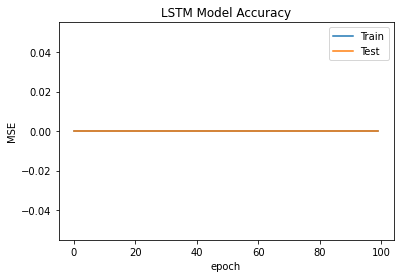

In [ ]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Berkeley/LSTM Model MSE.png')
plt.show()

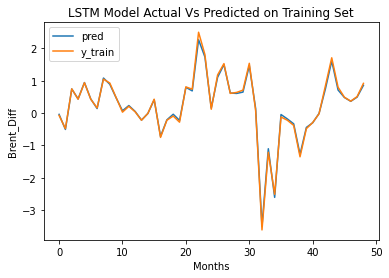

In [ ]:
lstm_train_pred = lstm_model.predict(X_train)
plt.plot(lstm_train_pred[:,0])
plt.plot(y_train)
plt.legend(['pred', 'y_train'])
plt.title('LSTM Model Actual Vs Predicted on Training Set')
plt.xlabel('Months')
plt.ylabel('Brent_Diff')
plt.savefig('/content/drive/MyDrive/Berkeley/LSTM Model Actual Vs Predicted Training Set.png')

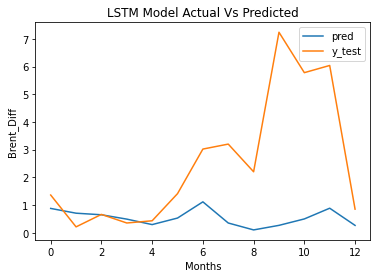

In [ ]:
lstm_pred = lstm_model.predict(X_test)
plt.plot(lstm_pred[:,0])
plt.plot(y_test)
plt.legend(['pred', 'y_test'])
plt.title('LSTM Model Actual Vs Predicted')
plt.xlabel('Months')
plt.ylabel('Brent_Diff')
plt.savefig('/content/drive/MyDrive/Berkeley/LSTM Model Actual Vs Predicted on Test Set.png')

## GRU Model

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(500, activation = 'relu', input_shape=(None, X_train.shape[-1]), return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1, activation = 'linear'))
gru_model.compile(loss='mse', metrics = ['mse', 'accuracy'], optimizer = 'rmsprop')
gru_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, None, 500)         1038000   
                                                                 
 dropout_21 (Dropout)        (None, None, 500)         0         
                                                                 
 dense_12 (Dense)            (None, None, 1)           501       
                                                                 
Total params: 1,038,501
Trainable params: 1,038,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%timeit
gru_history = lstm_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, verbose=0)

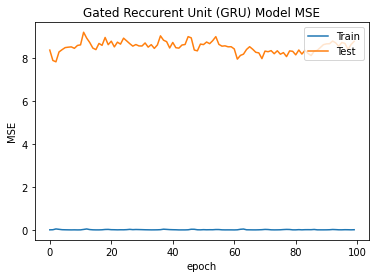

In [ ]:
plt.plot(gru_history.history['mse'])
plt.plot(gru_history.history['val_mse'])
plt.title('Gated Reccurent Unit (GRU) Model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Berkeley/GRU Model MSE.png')
plt.show()

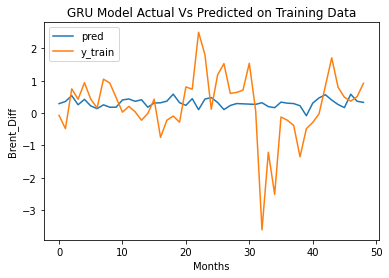

In [ ]:
gru_train_pred = gru_model.predict(X_train)
plt.plot(gru_train_pred[:,0])
plt.plot(y_train)
plt.legend(['pred', 'y_train'])
plt.title('GRU Model Actual Vs Predicted on Training Data')
plt.xlabel('Months')
plt.ylabel('Brent_Diff')
plt.savefig('/content/drive/MyDrive/Berkeley/GRU Model Actual Vs Predicted Train Set.png')

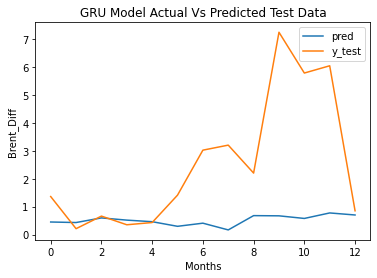

In [ ]:
gru_pred = gru_model.predict(X_test)
plt.plot(gru_pred[:,0])
plt.plot(y_test)
plt.legend(['pred', 'y_test'])
plt.title('GRU Model Actual Vs Predicted Test Data')
plt.xlabel('Months')
plt.ylabel('Brent_Diff')
plt.savefig('/content/drive/MyDrive/Berkeley/GRU Model Actual Vs Predicted on Test Data.png')